### Drive mounted

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Libraries

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import savemat
import glob
import tensorflow as tf

In [ ]:
import pandas as pd
from pathlib import Path
import os.path

from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

### Import data

In [ ]:
cwd = os.getcwd()
parent_dir = os.path.abspath(os.path.join(cwd, os.pardir))
data_dir = os.path.join(parent_dir, '/content/drive/MyDrive/Data')


(1800, 61, 38)


In [ ]:
#Load output
inund_path = os.path.join(data_dir, 'max_inundation.npz')
f = np.load(inund_path)

inund_px_all = f['inund_px_all']
print(inund_px_all)
runup_all = f['runup_all']
print(runup_all)

[[42406 20368 33223 ... 43708 14263 37671]
 [20532  2998 17103 ... 21193  1748 18695]
 [12449  7629 18873 ... 14612 12952 20342]
 [31688 13616 38081 ... 37689 31019 44962]]
[[27.53028   13.45226   14.544578  ... 28.72145   11.79781   17.56842  ]
 [21.864077   8.075708  12.1943    ... 24.117697   6.8936048 12.775737 ]
 [ 5.6379924  4.387614   6.8395944 ...  7.106493   5.002276   8.13023  ]
 [ 7.0145435  3.9379947  5.87162   ...  7.3811436  5.191113   7.8299556]]


In [ ]:
# Load uplift sources
dz_path = os.path.join(data_dir, 'uplift.npz')
f = np.load(dz_path)

dz_all = f['dz_all'].astype(np.float32)
extent_uplift = f['extent_uplift']
print(dz_all.shape)

(1800, 150, 132)


### Image visualization

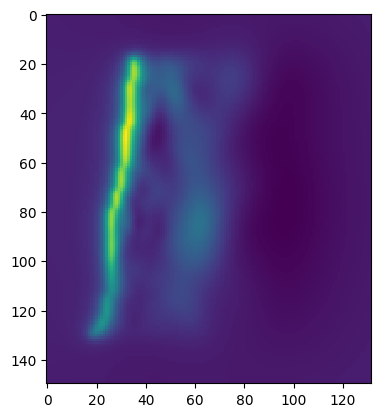

In [ ]:
darr = dz_all[0]
plt.imshow(darr, interpolation='nearest')
plt.show()

In [ ]:
X = dz_all       #uplift image
Y1 = runup_all.T #run-up per city 1st: Viña del Mar  2nd: Valparaíso  3rd: Cartagena  4th:San Antonio

In [ ]:
Y2 = inund_px_all.T/68771  # inundation area normalized per city 1st: Viña del Mar  2nd: Valparaíso  3rd: Cartagena  4th:San Antonio

In [ ]:
Y = np.hstack((Y1,Y2))  # run-up and inundation area
Y.shape

(1800, 8)

### Data preparation

In [ ]:
#split data 80 and 20%
X_train, X_test = train_test_split(X, train_size=0.8, shuffle=True, random_state=1) # this split the uplift data
Y_train, Y_test = train_test_split(Y, train_size=0.8, shuffle=True, random_state=1) # this split the run-up and inundation area data

In [ ]:
print(np.shape(X_train)) # should be (1440, 150, 132)
print(np.shape(Y_train)) # should be (1440, 8)

(1440, 150, 132)
(1440, 8)


In [ ]:
train_images = X_train
train_labels = Y_train
test_images = X_test
test_labels = Y_test

In [ ]:
max(train_images.max(), test_images.max())


10.296875

In [ ]:
max(train_labels.max(), test_labels.max())

40.15982437133789

In [ ]:
# Normalize the images.
train_images = (train_images / 10.296875)
test_images = (test_images / 10.296875)


In [ ]:
# Reshape the images.
train_images = np.expand_dims(train_images, axis=3)
test_images = np.expand_dims(test_images, axis=3)

print(train_images.shape) # (1440, 150, 132, 1)
print(test_images.shape)  # (360, 150, 132, 1)

(1440, 150, 132, 1)
(360, 150, 132, 1)


### 2D CNN model

In [ ]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten
from tensorflow.keras import datasets, layers, models, regularizers

L2 = 0.0001

model = models.Sequential()
model.add(layers.Conv2D(64, (6, 6), activation='relu', input_shape=(150, 132, 1), kernel_regularizer=regularizers.l2(L2)))
model.add(layers.MaxPooling2D((6, 6)))
model.add(layers.Conv2D(64, (2, 2), activation='relu', kernel_regularizer=regularizers.l2(L2)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (2, 2), activation='relu', kernel_regularizer=regularizers.l2(L2)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(Flatten())
model.add(layers.Dense(96, activation='relu', kernel_regularizer=regularizers.l2(L2)))
model.add(layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(L2)))
model.add(layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(L2)))
model.add(layers.Dense(64, activation='linear', kernel_regularizer=regularizers.l2(L2)))
model.add(layers.Dense(8))

In [ ]:
model.compile(loss='mean_squared_error', optimizer='adam' , metrics=['mean_squared_error'])

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 145, 127, 64)      2368      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 24, 21, 64)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 23, 20, 64)        16448     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 11, 10, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 10, 9, 64)         16448     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 5, 4, 64)         0

### Training

In [ ]:
history = model.fit(train_images, train_labels, epochs=200, batch_size = 32,
                    validation_data=(test_images, test_labels))

Epoch 1/200
45/45 [==============================] - 13s 14ms/step - loss: 19.5411 - mean_squared_error: 19.4970 - val_loss: 6.4795 - val_mean_squared_error: 6.4410
Epoch 2/200
45/45 [==============================] - 0s 7ms/step - loss: 4.3308 - mean_squared_error: 4.2947 - val_loss: 3.3764 - val_mean_squared_error: 3.3421
Epoch 3/200
45/45 [==============================] - 0s 7ms/step - loss: 2.8095 - mean_squared_error: 2.7762 - val_loss: 3.0618 - val_mean_squared_error: 3.0295
Epoch 4/200
45/45 [==============================] - 0s 7ms/step - loss: 2.0351 - mean_squared_error: 2.0033 - val_loss: 1.5891 - val_mean_squared_error: 1.5577
Epoch 5/200
45/45 [==============================] - 0s 8ms/step - loss: 1.4595 - mean_squared_error: 1.4283 - val_loss: 1.6650 - val_mean_squared_error: 1.6340
Epoch 6/200
45/45 [==============================] - 0s 8ms/step - loss: 1.2313 - mean_squared_error: 1.2004 - val_loss: 1.2075 - val_mean_squared_error: 1.1768
Epoch 7/200
45/45 [===========

In [ ]:
plt.plot(history.history['mean_squared_error'], label = 'training MSE', color="k")
plt.plot(history.history['val_mean_squared_error'], label = 'validation MSE', color="gray")
plt.tick_params(direction='out', length=5, width=1, colors='k',
               grid_color='g', grid_alpha=0.5, labelsize='x-large')
plt.grid(color='g', linestyle='--', linewidth=0.5)
plt.yscale('log')
plt.legend()
plt.ylabel('MSE')
plt.xlabel('epochs')

y_star_train = model.predict(train_images)
y_star_test = model.predict(test_images)

print(np.shape(y_star_train))
print(np.shape(y_star_test))

MSE_test = np.average((y_star_test - test_labels)**2)
MSE_train = np.average((y_star_train - train_labels )**2)
print('MSE test:', MSE_test)
print('MSE train:', MSE_train)

In [ ]:
predictions = model.predict(test_images)
train_predictions = model.predict(train_images)

45/45 [==============================] - 0s 2ms/step


Text(0.5, 0.01, 'NSWE simulations[km²]')

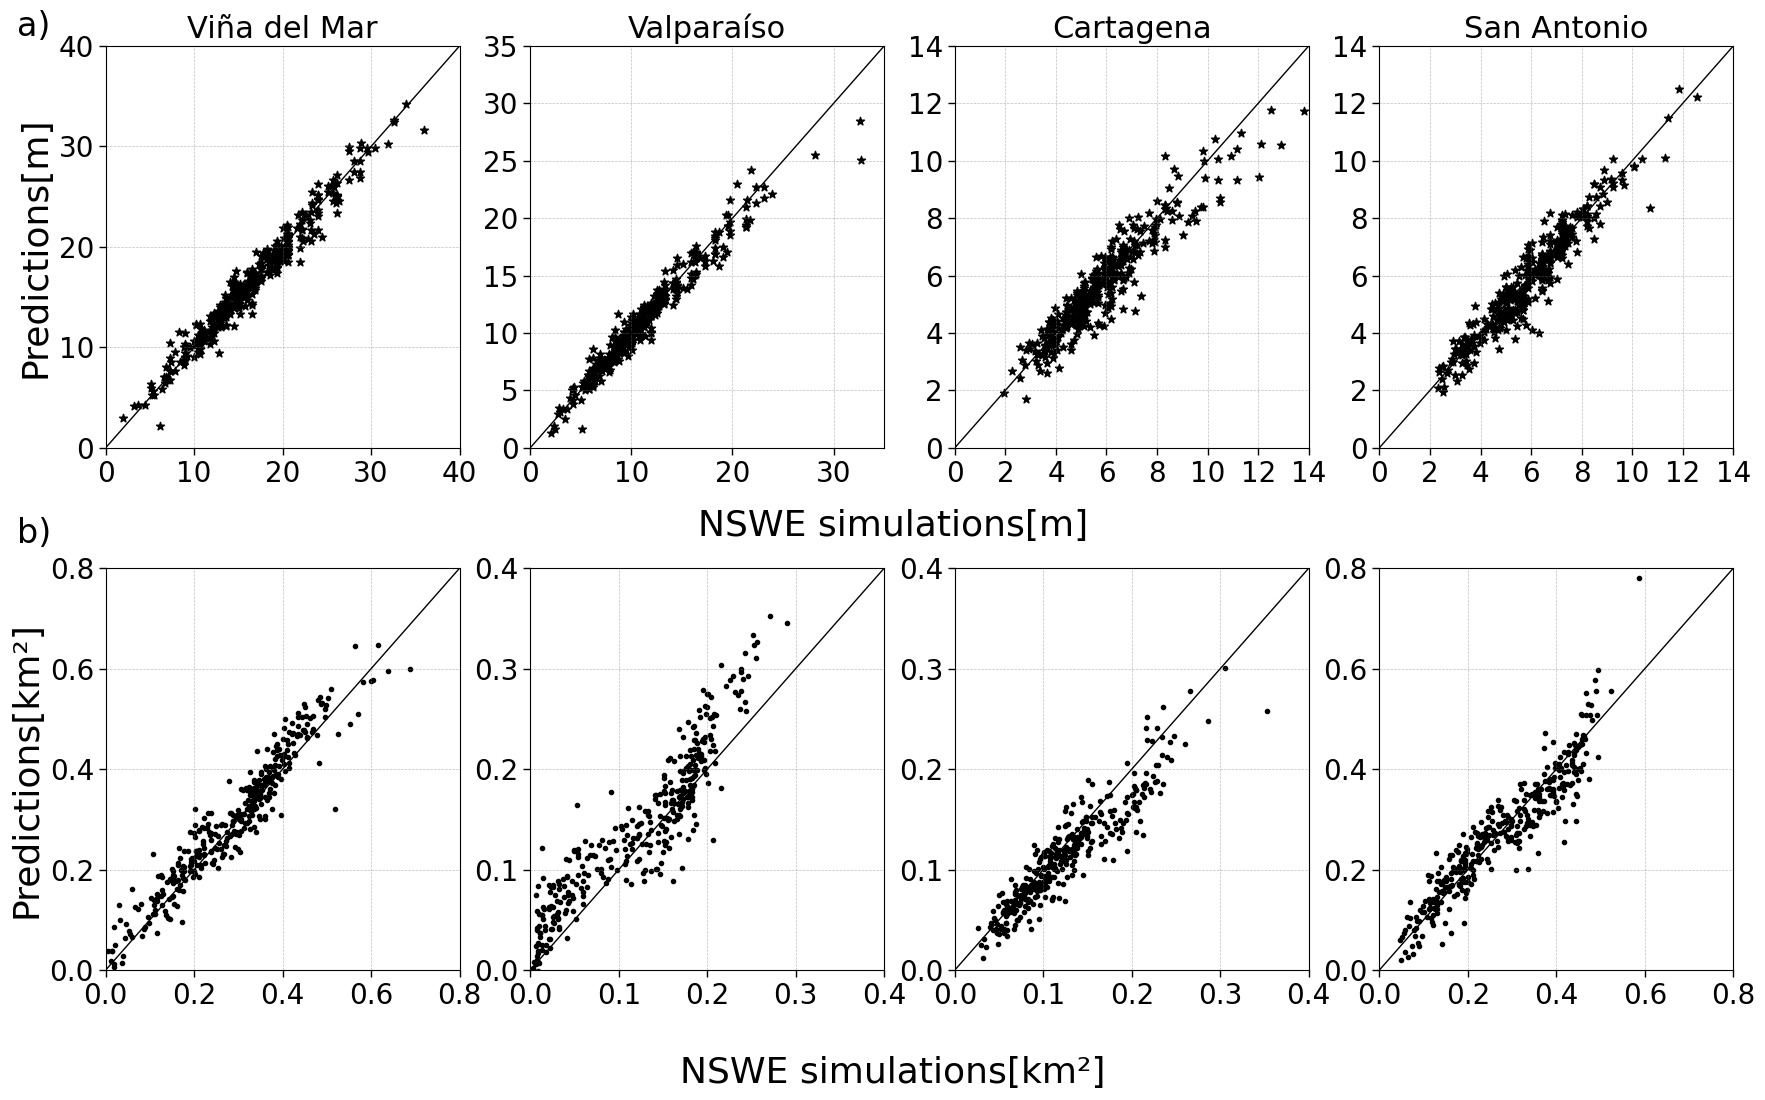

In [ ]:
from matplotlib.ticker import MaxNLocator, MultipleLocator

f, ax = plt.subplots(2, 4, figsize=(21, 12), gridspec_kw={'hspace': 0.3})

#Plot run-up

ax[0,0].scatter(test_labels[:,0], predictions[:,0], color = 'k', marker = '*', label='Run-up')
ax[0,0].set_title("Viña del Mar",fontsize = 22)
ax[0,0].set_ylabel('Predictions[m]',fontsize = 26 )
ax[0,0].tick_params(direction='out', length=5, width=1, colors='k',
               grid_color='gray', grid_alpha=0.5, labelsize='x-large')
ax[0,0].tick_params(axis="x", labelsize=20)
ax[0,0].tick_params(axis="y", labelsize=20)
ax[0,0].grid(color='gray', linestyle='--', linewidth=0.5)
ax[0,0].set_xlim([0, 40])
ax[0,0].set_ylim([0, 40])
ax[0,0].axline([0,0], [1,1], color="k", linewidth=1)
ax[0,0].text(-10, 41, 'a)', fontsize = 24)
ax[0,0].text(-10, -9.5, 'b)', fontsize = 24)

ax[0,1].scatter(test_labels[:,1], predictions[:,1], color = 'k', marker = '*', label='Run-up')
ax[0,1].set_title("Valparaíso",fontsize = 22)
ax[0,1].tick_params(direction='out', length=5, width=1, colors='k',
               grid_color='gray', grid_alpha=0.5, labelsize='x-large')
ax[0,1].tick_params(axis="x", labelsize=20)
ax[0,1].tick_params(axis="y", labelsize=20)
ax[0,1].grid(color='gray', linestyle='--', linewidth=0.5)
ax[0,1].set_xlim([0, 35])
ax[0,1].set_ylim([0, 35])
ax[0,1].axline([0,0], [1,1], color="k", linewidth=1)


ax[0,2].scatter(test_labels[:,2], predictions[:,2], color = 'k', marker = '*', label='Run-up')
ax[0,2].set_title("Cartagena", fontsize = 22)
ax[0,2].tick_params(direction='out', length=5, width=1, colors='k',
               grid_color='gray', grid_alpha=0.5, labelsize='x-large')
ax[0,2].grid(color='gray', linestyle='--', linewidth=0.5)
ax[0,2].tick_params(axis="x", labelsize=20)
ax[0,2].tick_params(axis="y", labelsize=20)
ax[0,2].set_xlim([0, 14])
ax[0,2].set_ylim([0, 14])
ax[0,2].axline([0,0], [1,1], color="k", linewidth=1)
ax[0,2].xaxis.set_major_locator(MaxNLocator(integer=True))
ax[0,2].yaxis.set_major_locator(MaxNLocator(integer=True))


ax[0,3].scatter(test_labels[:,3], predictions[:,3], color = 'k', marker = '*', label='Run-up')
ax[0,3].set_title("San Antonio", fontsize = 22)
ax[0,3].tick_params(direction='out', length=5, width=1, colors='k',
               grid_color='gray', grid_alpha=0.5, labelsize='x-large')
ax[0,3].grid(color='gray', linestyle='--', linewidth=0.5)
ax[0,3].tick_params(axis="x", labelsize=20)
ax[0,3].tick_params(axis="y", labelsize=20)
ax[0,3].set_xlim([0, 14])
ax[0,3].set_ylim([0, 14])
ax[0,3].axline([0,0], [1,1], color="k", linewidth=1)
ax[0,3].xaxis.set_major_locator(MaxNLocator(integer=True))
ax[0,3].yaxis.set_major_locator(MaxNLocator(integer=True))


f.text(0.5, 0.48, 'NSWE simulations[m]', ha='center', va='center', fontsize=26)


#Plot inundation area

ax[1,0].scatter(test_labels[:,4]*68771*1e-5, predictions[:,4]*68771*1e-5, color = 'k', marker = '.', label='Inundation area')
ax[1,0].set_ylabel('Predictions[km²]',fontsize = 26 )
ax[1,0].tick_params(direction='out', length=5, width=1, colors='k',
               grid_color='gray', grid_alpha=0.5, labelsize='x-large')
ax[1,0].tick_params(axis="x", labelsize=20)
ax[1,0].tick_params(axis="y", labelsize=20)
ax[1,0].grid(color='gray', linestyle='--', linewidth=0.5)
ax[1,0].set_xlim([0, .8])
ax[1,0].set_ylim([0, .8])
ax[1,0].axline([0,0], [1,1], color="k", linewidth=1)


ax[1,1].scatter(test_labels[:,5]*68771*1e-5, predictions[:,5]*68771*1e-5, color = 'k', marker = '.', label='Inundation area')
ax[1,1].tick_params(direction='out', length=5, width=1, colors='k',
               grid_color='gray', grid_alpha=0.5, labelsize='x-large')
ax[1,1].tick_params(axis="x", labelsize=20)
ax[1,1].tick_params(axis="y", labelsize=20)
ax[1,1].grid(color='gray', linestyle='--', linewidth=0.5)
ax[1,1].set_xlim([0, .4])
ax[1,1].set_ylim([0, .4])
ax[1,1].axline([0,0], [1,1], color="k", linewidth=1)


ax[1,2].scatter(test_labels[:,6]*68771*1e-5, predictions[:,6]*68771*1e-5, color = 'k', marker = '.', label='Inundation area')
ax[1,2].tick_params(direction='out', length=5, width=1, colors='k',
               grid_color='gray', grid_alpha=0.5, labelsize='x-large')
ax[1,2].tick_params(axis="x", labelsize=20)
ax[1,2].tick_params(axis="y", labelsize=20)
ax[1,2].grid(color='gray', linestyle='--', linewidth=0.5)
ax[1,2].set_xlim([0, .4])
ax[1,2].set_ylim([0, .4])
ax[1,2].axline([0,0], [1,1], color="k", linewidth=1)


ax[1,3].scatter(test_labels[:,7]*68771*1e-5, predictions[:,7]*68771*1e-5, color = 'k', marker = '.', label='Inundation area')
ax[1,3].tick_params(direction='out', length=5, width=1, colors='k',
               grid_color='gray', grid_alpha=0.5, labelsize='x-large')
ax[1,3].tick_params(axis="x", labelsize=20)
ax[1,3].tick_params(axis="y", labelsize=20)
ax[1,3].grid(color='gray', linestyle='--', linewidth=0.5)
ax[1,3].set_xlim([0, .8])
ax[1,3].set_ylim([0, .8])
ax[1,3].axline([0,0], [1,1], color="k", linewidth=1)


f.supxlabel('NSWE simulations[km²]',fontsize = 26)


## Uncertainty quantification - Ensemble model (Osband et al., 2018)
### Prior and training model

In [ ]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten,Lambda, add,  Activation, concatenate, Input, Embedding
from tensorflow.keras import datasets, layers, models, regularizers
from tensorflow.keras.optimizers import Adam, RMSprop
import tensorflow as tf
import tensorflow_probability as tfp
from tensorflow.keras.losses import MeanSquaredError
tfd = tfp.distributions
tfpl = tfp.layers

In [ ]:
# prior network output #

# shared input of the network
net_input = Input(shape=(150, 132, 1),name='input')

# let us build the prior network
L2 = 0.0001
prior_net = Sequential([
  Conv2D(64, (6, 6), activation='relu', input_shape=(150, 132, 1), kernel_regularizer=regularizers.l2(L2)),
  MaxPooling2D(pool_size= (6,6)),
  Conv2D(64, (2, 2),  activation='relu', kernel_regularizer=regularizers.l2(L2)),
  MaxPooling2D (pool_size= (2,2)),
  Conv2D(64, (2, 2),  activation='relu', kernel_regularizer=regularizers.l2(L2)),
  MaxPooling2D (pool_size= (2,2)),
  Flatten(),
  Dense(96, 'relu', kernel_initializer='glorot_normal',trainable=False, kernel_regularizer=regularizers.l2(L2)),
  Dense(64, 'relu', kernel_initializer='glorot_normal',trainable=False, kernel_regularizer=regularizers.l2(L2)),
  Dense(64, 'relu', kernel_initializer='glorot_normal',trainable=False, kernel_regularizer=regularizers.l2(L2)),
  Dense(64, 'relu', kernel_initializer='glorot_normal',trainable=False, kernel_regularizer=regularizers.l2(L2)),
], name='prior_net')(net_input)

prior_output = Dense(8,'linear',kernel_initializer='glorot_normal',
                     trainable=False, name='prior_out')(prior_net)

# compiling a model for this network
prior_model = Model(inputs=net_input, outputs=prior_output)


In [ ]:
# adding trainable network

# trainable network body

trainable_net = Sequential([
  Conv2D(64, (6, 6), activation='relu', input_shape=(150, 132, 1), kernel_regularizer=regularizers.l2(L2)),
  MaxPooling2D(pool_size= (6,6)),
  Conv2D(64, (2, 2),  activation='relu', kernel_regularizer=regularizers.l2(L2)),
  MaxPooling2D (pool_size= (2,2)),
  Conv2D(64, (2, 2),  activation='relu', kernel_regularizer=regularizers.l2(L2)),
  MaxPooling2D (pool_size= (2,2)),
  Flatten(),
  Dense(96, 'relu', kernel_regularizer=regularizers.l2(L2)),
  Dense(64, 'relu', kernel_regularizer=regularizers.l2(L2)),
  Dense(64, 'relu', kernel_regularizer=regularizers.l2(L2)),
  Dense(64, 'relu',  kernel_regularizer=regularizers.l2(L2)),
], name='trainable_net')(net_input)

# trainable network output

trainable_output = Dense(8,'linear', name='trainable_out')(trainable_net)

# using a lambda layer so we can control the weight (beta) of the prior network

prior_scale = Lambda(lambda x: x * 30, name='prior_scale')(prior_output) #beta=30 = sd*5 = 12091*5

# lastly, we use a add layer to add both networks together and get Q

add_output = add([trainable_output, prior_scale], name='add')

# defining the model
model = Model(inputs=net_input, outputs=add_output)

trainable_model = Model(inputs=model.input, outputs=model.get_layer('trainable_out').output)

In [ ]:
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input (InputLayer)             [(None, 150, 132, 1  0           []                               
                                )]                                                                
                                                                                                  
 prior_net (Sequential)         (None, 64)           172768      ['input[0][0]']                  
                                                                                                  
 trainable_net (Sequential)     (None, 64)           172768      ['input[0][0]']                  
                                                                                                  
 prior_out (Dense)              (None, 8)            520         ['prior_net[0][0]']        

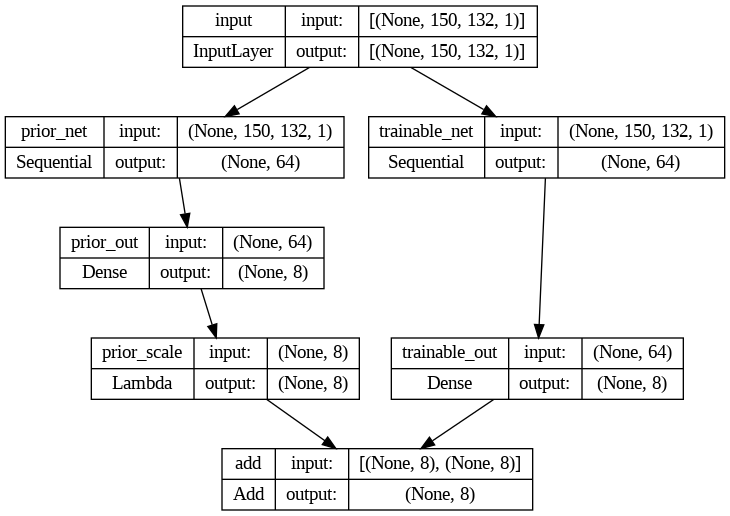

In [ ]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

dot_img_file = '/tmp/model_1.png'
tf.keras.utils.plot_model(model, to_file=dot_img_file, show_shapes=True)

### Test: varying the number of trained neural networks

In [ ]:
import time

#running 10,20,30,50,100,200 NNs

nsims=200

#prior_pred = prior_model.predict(test_images)
#train_predict = np.zeros([360,8,nsims])

y_star_train= np.zeros([1440,8,nsims])
y_star_test = np.zeros([360,8,nsims])
times= np.zeros(nsims)


for i in range(nsims):
  start = time.time()

  model = Model(inputs=net_input, outputs=add_output)
  trainable_model = Model(inputs=model.input, outputs=model.get_layer('trainable_out').output)
  model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mean_squared_error'])
  history = model.fit(train_images, train_labels, epochs=200, batch_size = 32,validation_data=(test_images, test_labels))

  times[i]=time.time()-start
  y_star_test[:,:,i] = model.predict(test_images)
  y_star_train[:,:,i] = model.predict(train_images)


Streaming output truncated to the last 5000 lines.
45/45 [==============================] - 0s 9ms/step - loss: 0.0539 - mean_squared_error: 0.0039 - val_loss: 0.4741 - val_mean_squared_error: 0.4241
Epoch 115/200
45/45 [==============================] - 0s 9ms/step - loss: 0.0559 - mean_squared_error: 0.0059 - val_loss: 0.4692 - val_mean_squared_error: 0.4192
Epoch 116/200
45/45 [==============================] - 0s 10ms/step - loss: 0.0562 - mean_squared_error: 0.0063 - val_loss: 0.4717 - val_mean_squared_error: 0.4218
Epoch 117/200
45/45 [==============================] - 0s 9ms/step - loss: 0.0570 - mean_squared_error: 0.0070 - val_loss: 0.4766 - val_mean_squared_error: 0.4266
Epoch 118/200
45/45 [==============================] - 0s 9ms/step - loss: 0.0572 - mean_squared_error: 0.0072 - val_loss: 0.4673 - val_mean_squared_error: 0.4173
Epoch 119/200
45/45 [==============================] - 0s 9ms/step - loss: 0.0572 - mean_squared_error: 0.0072 - val_loss: 0.4740 - val_mean_square

In [ ]:
#visualization
print(y_star_test[0,:,:].T)

[[18.13888741 11.97347832  5.22211599 ...  0.29328603  0.18596101
   0.3841815 ]
 [17.19053268 11.81195068  5.02407789 ...  0.10942766  0.16731822
   0.28764009]
 [17.05547523 11.65983868  4.78964949 ...  0.11908114  0.18458307
   0.34337616]
 ...
 [17.13347626 12.1779232   4.61645222 ...  0.16862786  0.14947081
   0.42545712]
 [17.31863213 12.05045986  4.50109148 ...  0.17053854  0.13908839
   0.39880109]
 [17.56189537 12.01617146  4.47326279 ...  0.16501656  0.14482784
   0.39011836]]


In [ ]:
#save variables in .npy
np.save('../content/drive/MyDrive/Data/test_uplift_data1_bayesian_200.npy',y_star_test)
np.save('../content/drive/MyDrive/Data/train_uplift_data1_bayesian_200.npy',y_star_train)
np.save('../content/drive/MyDrive/Data/times_uplift_data1_bayesian_200.npy',times)

In [ ]:
#load variables
y_star_test=np.load('../content/drive/MyDrive/Data/test_uplift_data1_bayesian_200.npy')
y_star_train=np.load('../content/drive/MyDrive/Data/train_uplift_data1_bayesian_200.npy')
times=np.load('../content/drive/MyDrive/Data/times_uplift_data1_bayesian_200.npy')
print(y_star_test.shape)
print(y_star_train.shape)
print(times.shape)

(360, 8, 200)
(1440, 8, 200)
(200,)


In [ ]:
#Calculo de residuales, fijarse en el caso del area inundada,
#  yo en lo personal los separaria
nsims=200
residuales_test= np.zeros([360,8,nsims])
residuales_train= np.zeros([1440,8,nsims])

sumt=np.zeros(nsims)

for i in range(nsims):
  sumt[i]=sum(times[0:(i+1)])
  residuales_test[:,:,i]=y_star_test[:,:,i]-test_labels[:,:]
  residuales_train[:,:,i]=y_star_train[:,:,i]-train_labels[:,:]


print(residuales_train.shape)
print(residuales_test.shape)

(1440, 8, 200)
(360, 8, 200)


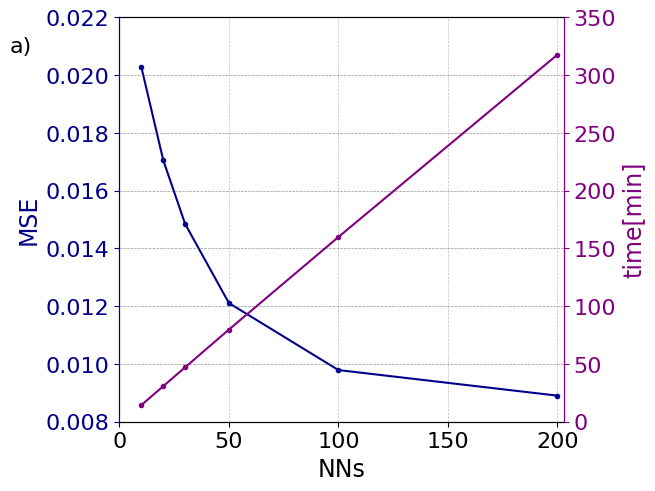

In [ ]:
#MSE accumulated
mse_test=np.zeros(nsims)
aux_test=np.zeros(nsims)

mse_train=np.zeros(nsims)
aux_train=np.zeros(nsims)

aux1=0
aux2=0
aux3=0

for i in range(nsims):
  #Train
  aux1=np.reshape(residuales_train[:,:,i],(-1,1))[:,0]
  aux_train[i]=np.dot(aux1,aux1)
  aux2=aux_train[i]+aux2
  mse_train[i]=aux2/(1440*8*(i+1)) #1440*8 or len(aux1)

  #Test
  aux1=np.reshape(residuales_test[:,:,i],(-1,1))[:,0]
  aux_test[i]=np.dot(aux1,aux1)
  aux3=aux_test[i]+aux3
  mse_test[i]=aux3/(360*8*(i+1))  #360*8 or len(aux1)

#MSE
mse_train10= mse_train[9]
mse_train20= mse_train[19]
mse_train30= mse_train[29]
mse_train50= mse_train[49]
mse_train100= mse_train[99]
mse_train200= mse_train[199]
mse = np.array((mse_train10, mse_train20, mse_train30, mse_train50, mse_train100, mse_train200))
#mse = np.array((mse_train10, mse_train20, mse_train30, mse_train50, mse_train100))

#time
time10= sum(times[0:9])/60
time20= sum(times[0:19])/60
time30= sum(times[0:29])/60
time50= sum(times[0:49])/60
time100= sum(times[0:99])/60
time200= sum(times[0:199])/60
time = np.array((time10, time20, time30, time50, time100, time200))
#time = np.array((time10, time20, time30, time50, time100))

NNs = np.array((10,20,30,50,100,200))

#Plots
fig, ax1 = plt.subplots(layout='constrained')

ax1.plot(NNs, mse,label='Train', marker= '.', color= 'darkblue')
ax1.set_xlabel('NNs', color='k', size=17)
ax1.set_ylabel('MSE', color='darkblue', size=17)
ax1.set_xlim([0,203])
ax1.set_ylim([0.008,0.022])
ax1.tick_params(axis='x', color='k', labelcolor='k', labelsize=16)
ax1.tick_params(axis='y', color='darkblue', labelcolor='darkblue', labelsize=16)


plt.grid(color='gray', linestyle='--', alpha= 0.5, linewidth=0.5)
ax2 = ax1.twinx()
ax2.plot(NNs, time,'purple', marker= '.')
ax2.set_ylabel('time[min]', color='purple', size=17)
ax2.set_ylim([0,350])
ax2.tick_params(axis='y', color='purple', labelcolor='purple', labelsize=16)
ax2.spines['right'].set_color('purple')
ax2.spines['left'].set_color('darkblue')

plt.grid(color='gray', linestyle='--', alpha= 0.5, linewidth=0.5)
plt.text (-50,320, "a)", fontsize= 16)
plt.show()


In [ ]:
# standard deviation and mean of the residuals

for i in range(nsims):
  if i==0:
    i=1
  aux_test=np.append(aux_test,residuales_test[:,:,i],axis=0)
  sigmas_test[:,i]=np.std(aux_test,axis=0)
  mus_test[:,i]=np.mean(aux_test,axis=0)

  aux_train=np.append(aux_train,residuales_train[:,:,i],axis=0)
  sigmas_train[:,i]=np.std(aux_train,axis=0)
  mus_train[:,i]=np.mean(aux_train,axis=0)



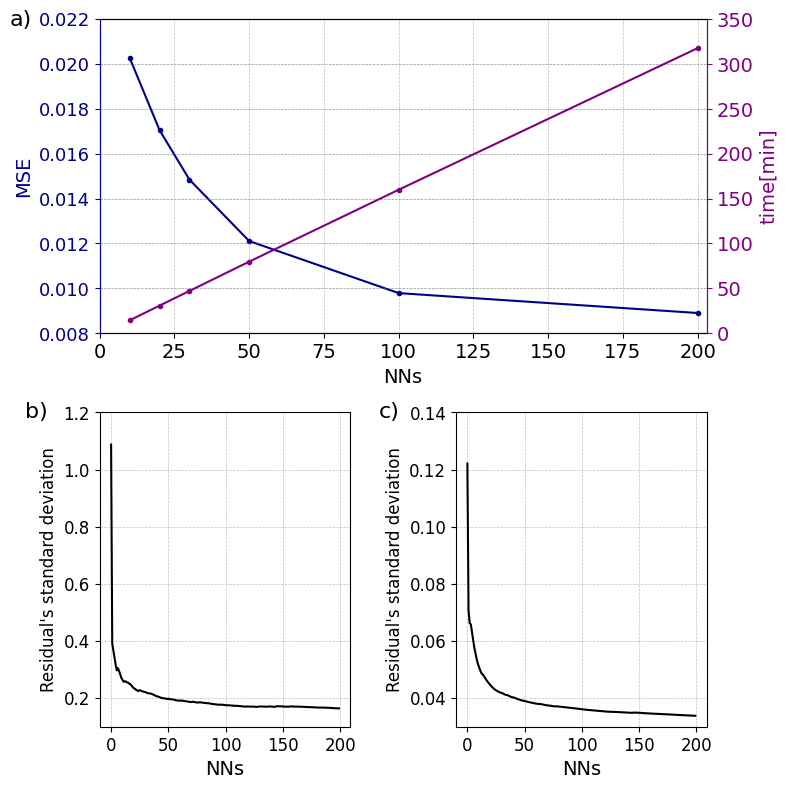

In [ ]:
from matplotlib.gridspec import GridSpec

# Subplot of comparison of number of NNs
fig = plt.figure(figsize=(8, 8))
gs = GridSpec(2, 2, figure=fig)

#Plot 1
ax1 = fig.add_subplot(gs[0, :])
ax1.plot(NNs, mse,label='Train', marker= '.', color= 'darkblue')
ax1.set_xlabel('NNs', color='k', size=14)
ax1.set_ylabel('MSE', color='darkblue', size=14)
ax1.set_xlim([0,203])
ax1.set_ylim([0.008,0.022])
ax1.tick_params(axis='x', color='k', labelcolor='k', labelsize=14)
ax1.tick_params(axis='y', color='darkblue', labelcolor='darkblue', labelsize=13)

plt.grid(color='gray', linestyle='--', alpha= 0.5, linewidth=0.5)
ax2 = ax1.twinx()
ax2.plot(NNs, time,'purple', marker= '.')
ax2.set_ylabel('time[min]', color='purple', size=14)
ax2.set_ylim([0,350])
ax2.tick_params(axis='y', color='purple', labelcolor='purple', labelsize=14)
ax2.spines['right'].set_color('purple')
ax2.spines['left'].set_color('darkblue')
plt.grid(color='gray', linestyle='--', alpha= 0.5, linewidth=0.5)
ax1.text (-30,0.0217, "a)", fontsize= 16)

#Plot 2
ax3 = fig.add_subplot(gs[1, 0])
ax3.plot(sigmas_train[0,:], 'k')
ax3.grid(color='gray', linestyle='--', alpha= 0.5, linewidth=0.5)
ax3.set_xlabel('NNs', color='k', size=14)
ax3.set_ylabel('Residual\'s standard deviation', color='k', size=12)
ax3.set_ylim([0.1,1.2])
ax3.tick_params(axis='y', color='k', labelcolor='k', labelsize=12)
ax3.tick_params(axis='x', color='k', labelcolor='k', labelsize=12)
ax3.text (-75,1.18, "b)", fontsize= 16)

#plot 3
ax4 = fig.add_subplot(gs[1, 1])
ax4.plot(sigmas_train[4,:], 'k')
ax4.grid(color='gray', linestyle='--', alpha= 0.5, linewidth=0.5)
ax4.set_xlabel('NNs', color='k', size=14)
ax4.set_ylabel('Residual\'s standard deviation', color='k', size=12)
ax4.set_ylim([0.03,0.14])
ax4.tick_params(axis='y', color='k', labelcolor='k', labelsize=12)
ax4.tick_params(axis='x', color='k', labelcolor='k', labelsize=12)
ax4.text (-77,0.138, "c)", fontsize= 16)
ax4.set

plt.tight_layout()
plt.show()

In [ ]:
predict = y_star_test[:,:,0:30]
print(predict.shape)
# standard deviation and mean
means=np.mean(predict[:,0,:], axis=1)
stddev=np.std(predict[:,0,:],axis=1,ddof=1)
print(means.shape)
print(stddev.shape)
print(np.max(stddev))

(360, 8, 30)
(360,)
(360,)
1.1500866385152508


### Plots mean of predictions vs real data

In [ ]:
y_true = test_labels[:,0]
y_pred= means

y=y_true
y_ihat=y_pred
y_bar=np.mean(y)


SSR=0
SST=0

for i in range(len(x)):
  SSR=SSR+(y[i]-y_ihat[i])**2
  SST=SST+(y[i]-y_bar)**2

Rsquared = 1- (SSR/SST)
print(Rsquared)

0.9639086325250935


### Plot standard deviation

<ipython-input-29-cb0287be5646>:16: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cb=plt.colorbar(mapper)


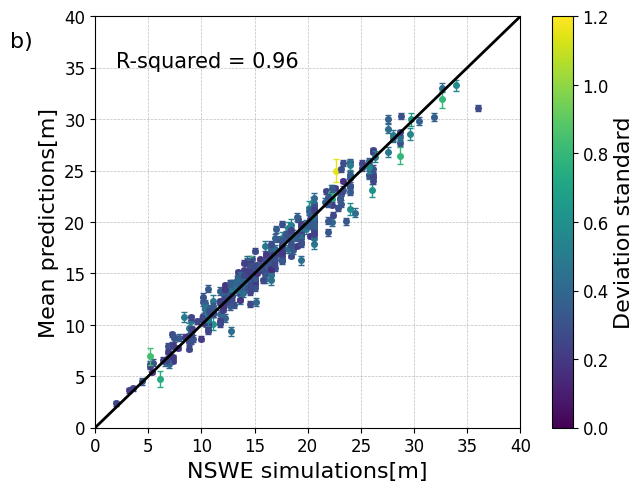

In [ ]:
x = test_labels[:,0]
y= means

yerr = stddev
fig, ax = plt.subplots(layout='constrained')

sc=plt.scatter(x,y, s=0.1, c=yerr)

#convert time to a color tuple using the colormap used for scatter
import matplotlib
import matplotlib.cm as cm
norm = matplotlib.colors.Normalize(vmin=0, vmax=1.2, clip=True)

mapper = cm.ScalarMappable(norm=norm, cmap='viridis')
time_color = np.array([(mapper.to_rgba(v)) for v in yerr])
cb=plt.colorbar(mapper)
cb.set_label("Deviation standard", fontsize = 16)
cb.ax.tick_params(labelsize=12)
#loop over each data point to plot
for X, Y, e, color in zip(x, y, yerr, time_color):
    plt.plot(X, Y, 'o', color=color,markersize=4)
    plt.errorbar(X, Y, e, lw=1, capsize=2, color=color)

#sns.regplot(data=df,x="Real data", y="Mean predictions", color="black", scatter=False, label= "Confidence 95%", ax=ax)
plt.text (-8,37, "b)", fontsize= 16)
plt.xlabel('NSWE simulations[m]',fontsize = 16)
plt.ylabel('Mean predictions[m]',fontsize = 16 )
plt.axline([0,0], [1,1], color="k", linewidth=2)
plt.text(2, 35, 'R-squared = %0.2f' % Rsquared, fontsize= 15)
plt.tick_params(axis="x", labelsize=12)
plt.tick_params(axis="y", labelsize=12)
#plt.title("Viña del mar", size=18)
plt.xlim([0, 40])
plt.ylim([0, 40])
plt.grid(color='gray', linestyle='--', linewidth=0.5, alpha=0.5)
#plt.legend(fontsize=10)

### Distribution of residuals

-2.2652726278557602
2.2568765140759504


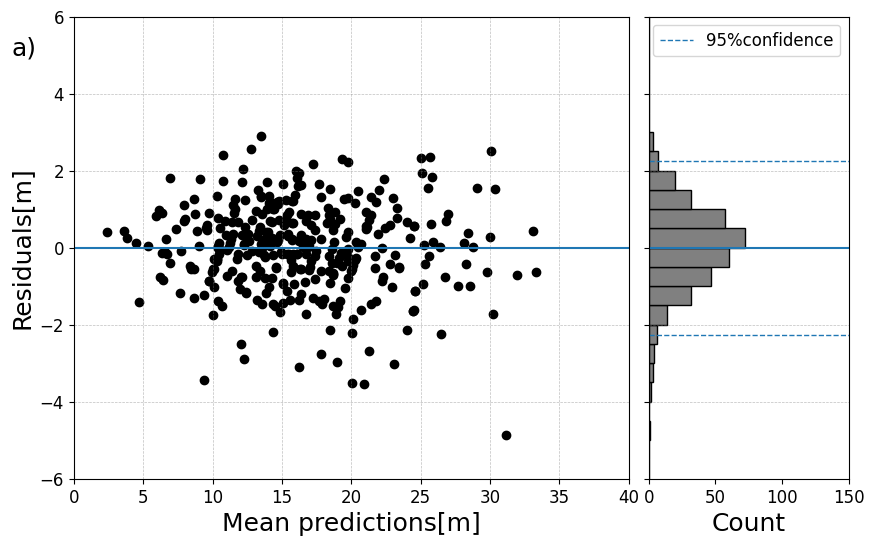

In [ ]:
from scipy import stats
mu, std = stats.norm.fit(residual)
from mpl_toolkits.axes_grid1 import make_axes_locatable

residual = y-x

fig, ax = plt.subplots(figsize=(10, 6))

# the scatter plot:
ax.scatter(y, residual, color='k')
ax.set_xlabel('Mean predictions[m]',fontsize = 18)
ax.set_ylabel('Residuals[m]',fontsize = 18 )
ax.tick_params(axis="x", labelsize=12)
ax.tick_params(axis="y", labelsize=12)
ax.grid(color='gray', linestyle='--', linewidth=0.5, alpha=0.5)
plt.axhline(y=0, linewidth=1.5)
plt.xlim([0, 40])
plt.ylim([-6, 6])
plt.text (-4.5,5, "a)", fontsize= 18)

# create new axes on the right and on the top of the current axes
divider = make_axes_locatable(ax)
# below height and pad are in inches
ax_histy = divider.append_axes("right",2, pad=0.2, sharey=ax)

# make some labels invisible
ax_histy.yaxis.set_tick_params(labelleft=False)
w=0.5
ax_histy.hist(residual, bins=np.arange(-6, 6 + w, w), edgecolor = 'black',orientation='horizontal', color='gray')
ax_histy.set_xlabel('Count',fontsize = 18)
ax_histy.tick_params(axis="x", labelsize=12)
ax_histy.set_xlim([0, 150])
ax_histy.grid(color='gray', axis='y', linestyle='--', linewidth=0.5, alpha=0.5)
plt.axhline(y=0, linewidth=1.5)

conf=mu-2*std
conf_=mu+2*std
print(conf)
print(conf_)
plt.axhline(y=conf, linestyle='--', linewidth=1, label="95%confidence")
plt.axhline(y=conf_, linestyle='--', linewidth=1)
ax_histy.legend(loc='best',fontsize = "large")
plt.show()